# 卷积层

why?
全连接处理图片 参数过多了

两个原则：
+ 平移不变性 这个地方找到的苹果 和 另一个地方找到的苹果应该是长相差不多的
+ 局部性 不用看全局，局部即可

what?
一个特殊的全连接层

互相关运算
![卷积](https://zh.d2l.ai/_images/correlation.svg)

In [66]:
import torch
from torch import nn
from d2l import torch as d2l
# 二维互相关
def corr2d(X,K):
    h,w = K.shape # 获取到卷积核的 height 和 width
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) # 通过输入 以及 卷积核的大小 计算出 输出的大小
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h,j:j+w]*K).sum()
    return Y

X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

In [67]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self,x):
        return corr2d(x,self.weight) + self.bias

# 图像当中的边缘检测

In [68]:
X = torch.ones((6,8))
X[:,2:6] = 0    # 限定 ： 所有行 每一行的 2-6列全部设置成0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [69]:
K = torch.tensor([[1.0,-1.0]])
Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [70]:
corr2d(X.t(),K)
# 通过这么一个测试，就能够说明 卷积核 K 只能检测垂直边缘没办法检测水平边缘

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

# 学习卷积核
上面是一个简单的检测垂直边缘的卷积核
但如果我想要检测一条鱼
那么我的卷积核总不能手动设置吧
因此，需要将卷积核里面的空当成超参数


But，怎么做到呢？
应该从    X -> Y 进行入手

通道的概念
+ in_channels 表示输入通道的数量，即输入特征图的深度。对于彩色图像，通常有3个通道（R、G、B），因此 in_channels 为3。如果是灰度图像，则 in_channels 为1。

+ out_channels 表示输出通道的数量，即输出特征图的深度。输出通道的数量决定了卷积层学习到的特征数量或抽象程度。通过调整 out_channels 的大小，我们可以控制卷积层学习到的特征的复杂度和表达能力。

In [71]:
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias=False)
# 这里reshape的原因是 二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度）
X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    print(f'epoch{i+1},loss{l.sum():.3f}')

epoch1,loss8.866
epoch2,loss3.636
epoch3,loss1.493
epoch4,loss0.614
epoch5,loss0.253
epoch6,loss0.104
epoch7,loss0.043
epoch8,loss0.018
epoch9,loss0.008
epoch10,loss0.003


In [72]:
conv2d.weight.data.reshape((1,2))
# 知道X , 知道 Y  推导卷积核的操作。
# 结果表明 推导的卷积核 与[-1,1] 差不太多，推导的很好。

tensor([[ 0.9880, -0.9922]])

特征映射： 输出的卷积层
感受野： 某一层的任意元素x在前向传播期间，有可能受到其他元素的影响。     （这里的其他元素就是“感受野”）

卷积层 & 卷积核
卷积核 作用在 卷积层上 得出 新的卷积层

# 填充和步幅

## 填充
why?
边界丢失的信息太多了

how?
边界填充


In [73]:
import torch
from torch import nn

def comp_conv2d(conv2d,X):
    X = X.reshape((1,1) + X.shape) #元组运算：(1,1) + (3,3) = (1, 1, 3, 3)
    Y = conv2d(X) # 计算的时候 是需要4个参数的
    return Y.reshape(Y.shape[2:]) # 省略前两个维度：批量大小和通道

conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1) # 卷积层对象
# 卷积核的参数并没有显示地给出，所以默认是随机初始化的。在 PyTorch 中，创建卷积层对象时，如果不指定卷积核的参数，则会使用默认的随机初始化方法来初始化卷积核的权重。

X = torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

卷积核的高度和宽度可以不同吗？
可以

In [74]:
conv2d = nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1)) # 先填充 然后再 卷积
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

# 调整步幅
why?
快速的降低输出的维数

how?
就是让卷积核多走几步 => 输出形状发生改变

变换主要靠的是 改变 stride参数


In [75]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2) # 每次向右2格，到头了 向下也是2格
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [76]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4)) # 每次向右3格，到头了向下是4格
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# 多输入多输出通道

what?
RGB 图像 三通道 => 3 * 宽 * 高
灰度图像 单通道 => 1 * 宽 * 高
![两个输入通道的互相关计算](https://zh.d2l.ai/_images/conv-multi-in.svg)

# 多输入通道

In [77]:
import torch
from d2l import torch as d2l

# X 是一个包含多个输入通道的三维张量（也可以看作是多张二维图像堆叠而成）
# K 是一个包含多个卷积核的四维张量（每个卷积核都有相同的深度，与输入通道数一致）。
def corr2d_multi_in(X,K):
    return sum(d2l.corr2d(x,k) for x,k in zip(X,K))

In [78]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

# 多输出通道

In [79]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)
# 对相同的 图片 使用不同的 kernel 得到了 多个卷积层

In [80]:
K = torch.stack((K, K + 1, K + 2), 0) # 三个二维的核，从0维度开始堆叠
#corr2d_multi_in_out(X, K) # X是输入
K.shape

torch.Size([3, 2, 2, 2])

In [81]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

# 1 * 1卷积层
1 * 1卷积的唯一计算发生在通道上。
width、height 都不变
但是channel数量会改变
原因： 图6.4.1两个输入通道的互相关计算。
见：https://zh.d2l.ai/chapter_convolutional-neural-networks/channels.html

In [82]:
def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w = X.shape # channel height width
    c_o = K.shape[0] # kernel数 决定out的 channel数
    X = X.reshape((c_i,h*w))
    K = K.reshape((c_o,c_i))
    Y = torch.matmul(K,X) # 这里用了一下矩阵的乘法，目的是加速。   它原本是三个channel，进行平铺，然后矩阵乘法，然后得到的是一个完整的矩阵，最后又拆开。
    return Y.reshape((c_o,h,w))

In [83]:
X = torch.normal(0,1,(3,3,3))
K = torch.normal(0,1,(2,3,1,1))

Y1 = corr2d_multi_in_out_1x1(X,K)
Y2 = corr2d_multi_in_out(X,K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# 汇聚层
why?
我们的机器学习任务通常会跟全局图像的问题有关,聚合信息，生成越来越粗糙的映射，最终实现学习全局表示的目标，同时将卷积图层的所有优势保留在中间层。

target:
1. 降低卷积层对位置的敏感性。
2. 降低对空间降采样表示的敏感性。

how?
1. 最大汇聚层（maximum pooling）
2. 平均汇聚层（average pooling）

In [86]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X,pool_size,mode='max'):
    p_h,p_w = pool_size
    Y = torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i,j] = X[i:i+p_h,j:j+p_w].max()
            elif mode == 'avg':
                Y[i,j] = X[i:i+p_h,j:j+p_w].mean()
    return Y

X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2)),pool2d(X, (2, 2), 'avg') # 输出最大池、平均池

(tensor([[4., 5.],
         [7., 8.]]),
 tensor([[2., 3.],
         [5., 6.]]))

# 填充和步幅
思路和之前的卷积层一样

In [87]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [90]:
pool2d = nn.MaxPool2d(2) #kernel_size = 2 深度学习框架中的步幅与汇聚窗口的大小相同
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [92]:
pool2d = nn.MaxPool2d(2, padding=1, stride=1) # 填充 + 调整步幅
pool2d(X)

tensor([[[[ 0.,  1.,  2.,  3.,  3.],
          [ 4.,  5.,  6.,  7.,  7.],
          [ 8.,  9., 10., 11., 11.],
          [12., 13., 14., 15., 15.],
          [12., 13., 14., 15., 15.]]]])

In [93]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1)) # 调整汇聚窗口
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

# 多个通道

前置知识：
torch.cat() 函数用于在指定维度上拼接（连接）多个张量。
它可以将多个具有相同形状的张量沿指定维度进行连接，生成一个新的张量。

In [94]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [95]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

卷积神经网络 LeNet

其实就是 卷积层 + 汇聚层 + 全连接层 穿起来


In [97]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), # 卷积层
    nn.AvgPool2d(kernel_size=2, stride=2), # 汇聚层
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), # 卷积层
    nn.AvgPool2d(kernel_size=2, stride=2), # 汇聚层
    nn.Flatten(), # 平铺 - 为了全连接层使用
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [98]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [99]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size = batch_size)

In [100]:
def evaluate_accuracy_gpu(net,data_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list): #如果 X 是 list类型
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [101]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

KeyboardInterrupt: 

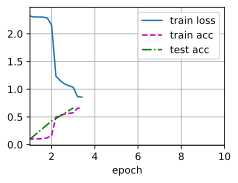

In [102]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())